# load R libraries and data directory

In [1]:
suppressMessages(library(RankProd)) 
suppressMessages(library(limma))
library(gplots)
library(plotrix)
library(RColorBrewer)
library(methods)
library(edgeR)
library(ggbiplot)
library(genefilter)

suppressMessages(library(gtools)) 
suppressMessages(library(Hmisc))
suppressMessages(library(minet))
suppressMessages(library(reshape2))
suppressMessages(library(plyr))
suppressMessages(library(outliers))
suppressMessages(library(magrittr))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(purrr))
suppressMessages(library(stringr))

library(tibble)
library(readr)

options(stringsAsFactors = FALSE)


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘plotrix’

The following object is masked from ‘package:gplots’:

    plotCI

Warning message:
: package ‘RColorBrewer’ was built under R version 3.3.0Loading required package: ggplot2
Loading required package: plyr
Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:plotrix’:

    rescale

Loading required package: grid

Attaching package: ‘genefilter’

The following object is masked from ‘package:base’:

    anyNA

Warning message:
: package ‘lattice’ was built under R version 3.3.0Warning message:
: package ‘reshape2’ was built under R version 3.3.0Warning message:
: package ‘magrittr’ was built under R version 3.3.0Warning message:
: package ‘stringr’ was built under R version 3.3.0
Attaching package: ‘tibble’

The following object is masked from ‘package:dplyr’:

    tbl_df


Attaching package: ‘readr’

The foll

In [2]:
stats_dir = '~/Downloads/base/test_smallonly/stat_mapped/'
counts_dir = '~/Downloads/base/test_smallonly/counts/'
pheno_csv = '~/data/GSK_enfisema/pheno_groups.csv'

# U219 mRNA related:
mRNA_working_dir = '/home/guillaume/Documents/GSK_enfisema/'

# percentage mapped

In [3]:
setwd('~/Downloads/')

fi = list.files(stats_dir)[grepl('mapped.txt',list.files(stats_dir))]

tab = read.table(paste(stats_dir,list.files(stats_dir)[grepl('mapped.txt',list.files(stats_dir))][1],sep = ''),
                 sep =  '+', fill = T) %>% as.data.frame %>% filter(grepl('total|mapped \\(',V2)) %>%
mutate(V2 = c('total','mapped')) %>% select(-V3) %>% mutate(sample = list.files(stats_dir)[grepl('mapped.txt',list.files(stats_dir))][1])

for (counts_file in fi[2:length(fi)]) {
    tab_next = read.table(paste(stats_dir, counts_file,sep = ''), sep =  '+', fill = T) %>% 
    as.data.frame %>% filter(grepl('total|mapped \\(',V2)) %>%
mutate(V2 = c('total','mapped')) %>% select(-V3) %>% mutate(sample = counts_file)
    
    tab = bind_rows(tab, tab_next) 
}

In [4]:
pre_align = tab %>% filter(grepl('total',V2)) %>% rowwise %>% 
  mutate(patient = strsplit(sample,split='_')[[1]][1],      
         pat = gsub('RF-','',patient),
         pat = gsub('RF','',pat),
         pat = gsub('-1','',pat),
         pat = gsub('-2','',pat),
         pat = gsub('-3','',pat)) %>% ungroup %>% arrange(V1) %>% mutate(ord = row_number(), patient = 
                                                                        factor(ord, labels = as.character(pat))) %>%
rename(total_read = V1)

first_align = tab %>% filter(grepl('mapped',V2)) %>%
rename(first_align = V1) %>% select(-V2) %>% left_join(pre_align) 

align = bind_rows(first_align %>% select(first_align, patient, pat, ord) %>% rename(n_reads = first_align) %>%
                  mutate(step = '2.first'),
first_align %>% select(total_read, patient, pat, ord) %>% mutate(step = '1.pre') %>% rename(n_reads = total_read))
align %>% head

Joining, by = "sample"


,n_reads,patient,pat,ord,step
1,259278,106,106,16,2.first
2,406276,107,107,29,2.first
3,201915,108,108,13,2.first
4,286783,109,109,22,2.first
5,301429,110,110,15,2.first
6,284261,113,113,19,2.first


In [5]:
##
fi = list.files(stats_dir)[grepl('mapped.t1.txt',list.files(stats_dir))]
tabt1 = read.table(paste(stats_dir,list.files(stats_dir)[grepl('mapped.t1.txt',list.files(stats_dir))][1],sep = ''),
                 sep =  '+', fill = T) %>% as.data.frame %>% filter(grepl('mapped \\(',V2)) %>% 
select(-V3) %>% mutate(sample = list.files(stats_dir)[grepl('mapped.t1.txt',list.files(stats_dir))][1])
for (counts_file in fi[2:length(fi)]) {
    tab_next = read.table(paste(stats_dir, counts_file,sep = ''), sep =  '+', fill = T) %>% 
    as.data.frame %>% select(-V3) %>% mutate(sample = counts_file)  %>% filter(grepl('mapped \\(',V2))
    
    tabt1 = bind_rows(tabt1, tab_next) }

##
fi = list.files(stats_dir)[grepl('mapped.t2.txt',list.files(stats_dir))]
tabt2 = read.table(paste(stats_dir,list.files(stats_dir)[grepl('mapped.t2.txt',list.files(stats_dir))][1],sep = ''),
                 sep =  '+', fill = T) %>% as.data.frame %>% filter(grepl('mapped \\(',V2)) %>% 
select(-V3) %>% mutate(sample = list.files(stats_dir)[grepl('mapped.t2.txt',list.files(stats_dir))][1])
for (counts_file in fi[2:length(fi)]) {
    tab_next = read.table(paste(stats_dir, counts_file,sep = ''), sep =  '+', fill = T) %>% 
    as.data.frame %>% select(-V3) %>% mutate(sample = counts_file)  %>% filter(grepl('mapped \\(',V2))
    
    tabt2 = bind_rows(tabt2, tab_next) }

##
fi = list.files(stats_dir)[grepl('mapped.t3.txt',list.files(stats_dir))]
tabt3 = read.table(paste(stats_dir,list.files(stats_dir)[grepl('mapped.t3.txt',list.files(stats_dir))][1],sep = ''),
                 sep =  '+', fill = T) %>% as.data.frame %>% filter(grepl('mapped \\(',V2)) %>% 
select(-V3) %>% mutate(sample = list.files(stats_dir)[grepl('mapped.t3.txt',list.files(stats_dir))][1])
for (counts_file in fi[2:length(fi)]) {
    tab_next = read.table(paste(stats_dir, counts_file,sep = ''), sep =  '+', fill = T) %>% 
    as.data.frame %>% select(-V3) %>% mutate(sample = counts_file)  %>% filter(grepl('mapped \\(',V2))
    
    tabt3 = bind_rows(tabt3, tab_next) }
##

align =                 tabt1 %>% mutate(step = '3.first_trim') %>% rename(n_reads = V1) %>% bind_rows(
tabt2 %>% mutate(step = '4.second_trim') %>% rename(n_reads = V1)) %>% bind_rows(
tabt3 %>% mutate(step = '5.third_trim') %>% rename(n_reads = V1)) %>% rowwise %>%
 mutate(patient = strsplit(sample,split='_')[[1]][1],      
         pat = gsub('RF-','',patient),
         pat = gsub('RF','',pat),
         pat = gsub('-1','',pat),
         pat = gsub('-2','',pat),
         pat = gsub('-3','',pat)) %>% ungroup %>% select(-sample,-patient) %>%
left_join( pre_align %>% select(pat, patient, ord) %>% distinct()) %>% 
select(-V2) %>% bind_rows(align)

Joining, by = "pat"


In [6]:
align %<>% filter(step != '1.pre') %>% arrange(pat, step) %>% 
mutate(n_reads_cumu = cumsum(n_reads)) %>% ungroup %>% bind_rows(
align %>% filter(step == '1.pre')) %>%
arrange(pat, step) %>% mutate(n_reads_cumu = ifelse(is.na(n_reads_cumu), n_reads, n_reads_cumu)) %>%
mutate(n_reads= n_reads / 1000000)

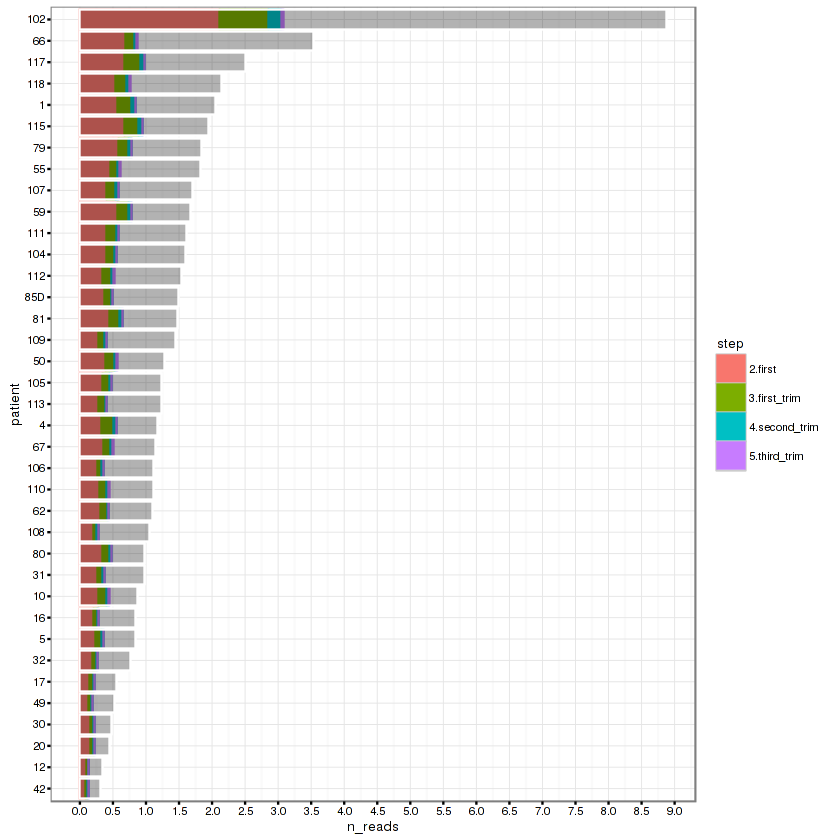

In [7]:
ggplot(align %>% filter(step != '1.pre')
       , aes(x = patient, y = n_reads, fill = step, color = step)) + geom_bar(stat = 'identity') +
theme_bw(8) +

geom_bar(data = align %>% filter(step == '1.pre')
       , aes(x = patient, y = n_reads)
         , stat = 'identity', alpha = 0.3, fill = 'black', color = 'white') +

coord_flip() + scale_y_continuous(breaks = pretty(align$n_reads, n = 20))

# get count matrix

In [8]:
setwd('~/Downloads/')

 tab = read.table(paste(counts_dir,list.files(counts_dir)[1],sep = '/')) %>% as.data.frame %>% rename(micro = V1, count = V3) %>% select(-V2, -V4) %>%
mutate(sub_micro = gsub('-1$','',micro),sub_micro=gsub('-2$','',sub_micro), sub_micro=gsub('-3$','',sub_micro)) %>%
group_by(sub_micro) %>% summarise(count = sum(count)) %>% arrange(desc(count)) %>% 
 #  filter(count > 0, !is.na(count)) %>%
filter(count > 0, !is.na(count), grepl('hsa-mi',sub_micro) | grepl('hsa-let',sub_micro) ) %>%
#filter(count > 0, !is.na(count), !grepl('hsa-mi',sub_micro), !grepl('hsa-let',sub_micro) ) %>%
    mutate(sample = list.files(counts_dir)[1])

tab %>% dim

for (counts_file in list.files(counts_dir)[2:length(list.files(counts_dir))]) {
    tab_next = read.table(paste(counts_dir,counts_file,sep = '/')) %>% as.data.frame %>% rename(micro = V1, count = V3) %>% select(-V2, -V4) %>%
mutate(sub_micro = gsub('-1$','',micro),sub_micro=gsub('-2$','',sub_micro), sub_micro=gsub('-3$','',sub_micro)) %>%
group_by(sub_micro) %>% summarise(count = sum(count)) %>% arrange(desc(count)) %>% 
#    filter(count > 0, !is.na(count)) %>%
filter(count > 0, !is.na(count), grepl('hsa-mi',sub_micro) | grepl('hsa-let',sub_micro) ) %>%
#filter(count > 0, !is.na(count), !grepl('hsa-mi',sub_micro), !grepl('hsa-let',sub_micro) ) %>%
    mutate(sample = counts_file)
    tab = bind_rows(tab, tab_next)
    #print(tab %>% dim)
}
#tab$sample %>% table

[1] 715   3

In [9]:
mat = tab %>% select(sample, sub_micro, count) %>% spread(., sub_micro, count, fill = 0)
#mat

# get pheno group info

In [10]:
groups = read.csv(pheno_csv,header = TRUE)
groups %>% head

,Fila.en.placa.arrays,pat,Género,Fumador,Edad,BMI,EPOC,X.FEV1.Pre.BD,GOLD.sobre.Fev1.pre,X..FVC.Pre.BD,FEV1.FVC.Pre,Pack.year,DLCO,TAC.Enfisema.comprobado,Pulmón..cáncer.,gold,batch
1,A1,1,Hombre,Ex-fumador,69,32.41,SI,82.54,GOLD I,88.54,66.28,44,84.30,NO,SI,3,f
2,A4,4,Hombre,Ex-fumador,63,27.25,SI,61.95,GOLD II,86.74,51.99,NA,129.83,NO,SI,22,f
3,A5,5,Hombre,Ex-fumador,76,30.10,SI,69.19,GOLD II,94.07,55.35,NA,86.72,NO,SI,20,f
4,A9,10,Hombre,Ex-fumador,64,26.81,SI,69.34,GOLD II,96.75,51.97,47,81.00,NO,SI,16,f
5,A10,12,Hombre,Ex-fumador,73,24.54,SI,82.62,GOLD I,100.67,62.54,25,106.77,NO,SI,6,f
6,B2,16,Mujer,Ex-fumador,64,29.75,SI,64.15,GOLD II,84.27,55.20,30,171.62,NO,SI,23,f


In [11]:
files <- mat$sample
pheno = data_frame(sample = files) %>% rowwise %>% 
  mutate(patient = strsplit(sample,split='_')[[1]][1],      
         pat = gsub('RF-','',patient),
         pat = gsub('RF','',pat),
         pat = gsub('-1','',pat),
         pat = gsub('-2','',pat),
         pat = gsub('-3','',pat)) %>% ungroup %>% left_join(groups) %>% mutate(dlco_group = ifelse(DLCO < 60,'disease','control')) #15 vs 22

pheno$dlco_group %>% table

Joining, by = "pat"


.
control disease 
     13      22 

In [12]:
data = mat %>% select(-sample)
data = as.matrix(data)
data %>% dim

[1]   35 2274

# pre-process pca

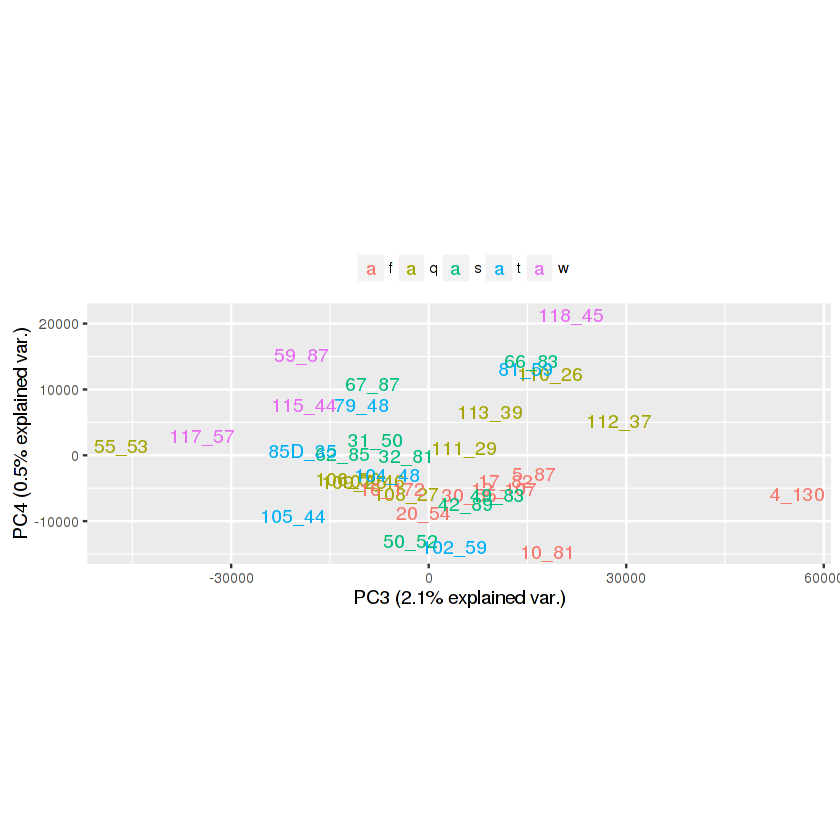

In [13]:
ir.pca <- prcomp(data)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 3:4, labels.size = 4,
              ellipse = F, circle = F, groups = pheno$batch,
              var.axes = F, labels = paste(pheno$pat %>% as.character, round(pheno$DLCO),sep='_'))
g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

# process raw counts with voom / limma

In [14]:
x = data %>% t

In [15]:
x %>% dim
res <- DGEList(counts=x, genes=row.names(x))
keep=rowSums(cpm(res, normalized.lib.sizes=FALSE)>=1)>=20
matrix=x[keep,]
matrix %>% dim
x = matrix
res <- DGEList(counts=matrix, genes=row.names(matrix))

#res$samples$lib.size <- unlist(lib_size[3])
result <- calcNormFactors(res, method="TMM") #method=c("TMM","RLE","upperquartile","none")

[1] 2274   35

[1] 607  35

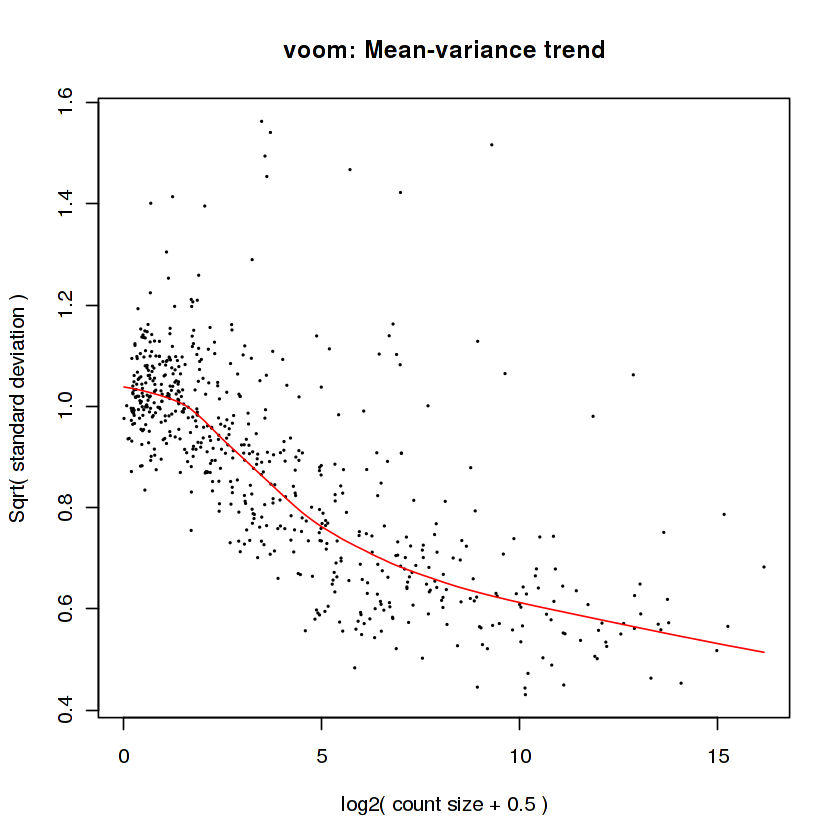

In [87]:
des = model.matrix(~ 1 + pheno$BMI + as.factor(pheno$batch) + as.factor(pheno$dlco_group))
#des = model.matrix(~ 1 + as.factor(pheno$batch) + pheno$DLCO)
v = voom(result, design = des, plot=T)#, normalize="quantile")

In [88]:
fit <- lmFit(v, des)
fit <- eBayes(fit, robust = T)
pvals = topTable(fit, coef = ncol(des), number= 2000, sort.by = 'P') 

limma_fdr_batchage25 = sum(pvals$adj.P.Val < 0.25)
limma_fdr_batchage05 = sum(pvals$adj.P.Val < 0.05)
limma_fdr_batchage01 = sum(pvals$adj.P.Val < 0.01)
limma_batchage05 = sum(pvals$P.Value < 0.05)
limma_batchage05
limma_fdr_batchage25
limma_fdr_batchage05
limma_fdr_batchage01

all_mirs = pvals %>% as.data.frame %>% mutate(fc = gtools::logratio2foldchange(logFC)) 
mirs = pvals %>% as.data.frame %>% mutate(fc = gtools::logratio2foldchange(logFC)) %>% 
filter(fc < -1.6 | fc > 1.6, P.Value < 0.05) %>%
arrange(desc(abs(fc))) %>% 
head(20)
mirs

[1] 21

[1] 0

[1] 0

[1] 0

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,fc
1,hsa-miR-889-3p,-1.7516437,2.615319,-3.441050,0.001376871,0.8357609,-4.415614,-3.367420
2,hsa-miR-3182,-1.3726915,4.171605,-2.029498,0.049953060,0.9569044,-4.529336,-2.589532
3,hsa-miR-10b-5p,-1.3527557,10.776801,-2.228357,0.033936159,0.9569044,-4.267285,-2.553995
4,hsa-miR-491-5p,-1.3365622,1.628261,-2.539249,0.015130475,0.9569044,-4.514766,-2.525488
5,hsa-miR-548f-5p,-1.3051011,1.751807,-2.269922,0.028712971,0.9569044,-4.530270,-2.471010
6,hsa-miR-744-3p,-1.2877514,1.752714,-2.400020,0.021174351,0.9569044,-4.523298,-2.441472
7,hsa-miR-4326,-1.2849010,1.625727,-2.270932,0.028646173,0.9569044,-4.532775,-2.436653
8,hsa-miR-369-5p,-1.2725441,2.633895,-2.092754,0.042805412,0.9569044,-4.541154,-2.415872
9,hsa-miR-1278,-1.2645658,2.548574,-2.497113,0.016768474,0.9569044,-4.507923,-2.402549
10,hsa-miR-3196,-1.2326290,1.841353,-2.787738,0.008103870,0.9569044,-4.493636,-2.349948


In [91]:
all_limma = all_mirs 
all_limma %>% colnames

[1] "genes"     "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"         "fc"

[1] 607  10

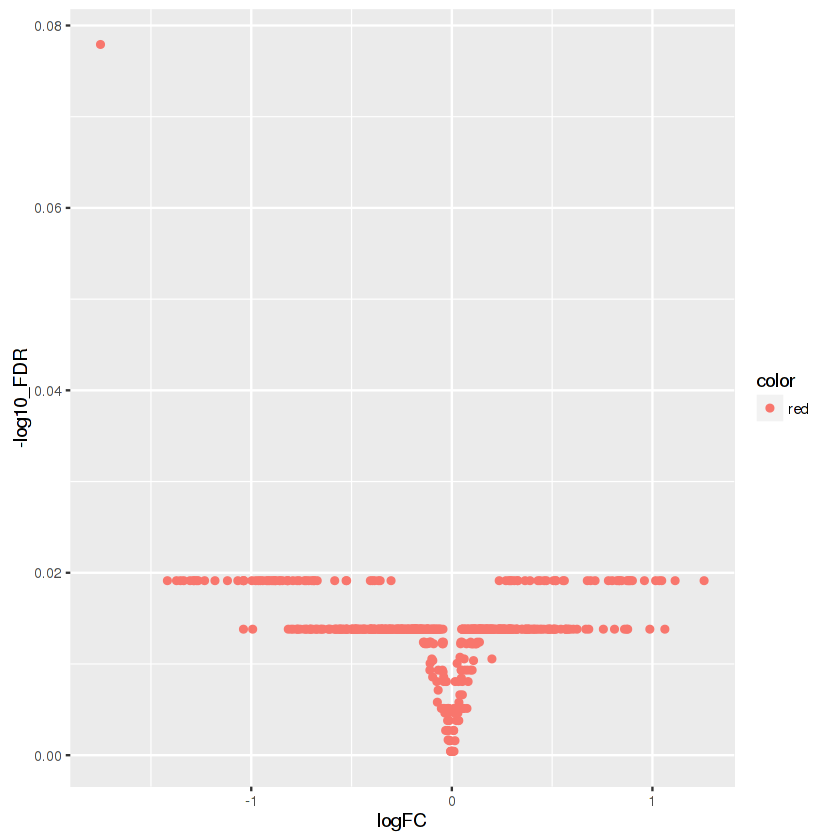

In [94]:
all_limma = all_mirs %>% mutate(
    log10_FDR = log10(adj.P.Val),
    color = ifelse(adj.P.Val < 0.05 & logratio2foldchange(logFC)>1.5,'green','red'))
all_limma %>% dim
ggplot(all_limma, aes(x=logFC, y = -log10_FDR, color=color)) + geom_point()

# plots on normalized counts

## log normalized counts
- remove batch and covariates (bmi, age etc..) 

In [18]:
nc <- cpm(res, normalized.lib.sizes=FALSE)
log.nc = log(nc+1)
colnames(log.nc) = pheno$sample
log.nc.filt = removeBatchEffect(log.nc, batch=as.factor(pheno$batch), 
                                covariates = cbind(pheno$BMI,pheno$Edad),
                                design = model.matrix(~ 1 + as.factor(pheno$dlco_group)))
##log.nc.filt = log.nc
log.nc.filt %>% head

,106-1_S17_L001_R1_001.fastq.assembled.fastq.full.count.txt,107_S13_L001_R1_001.fastq.assembled.fastq.full.count.txt,108-1_S12_L001_R1_001.fastq.assembled.fastq.full.count.txt,109-2_S16_L001_R1_001.fastq.assembled.fastq.full.count.txt,110-3_S15_L001_R1_001.fastq.assembled.fastq.full.count.txt,113_S14_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-102_S15_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF104_S4_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF105_S5_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-10_S17_L001_R1_001.fastq.assembled.fastq.full.count.txt,⋯,RF-50_S9_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF55-1_S10_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-59_S2_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-5_S16_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-62_S10_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-66_S9_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF67_S13_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF79_S2_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-81_S12_L001_R1_001.fastq.assembled.fastq.full.count.txt,RF-85D_S13_L001_R1_001.fastq.assembled.fastq.full.count.txt
hsa-let-7a-3p,5.258297,4.939931,4.792479,4.745570,5.187718,5.634513,4.770420,4.856507,5.066252,4.571531,⋯,4.699562,4.735244,5.165126,4.152871,5.462511,4.632009,5.345867,5.890803,4.998161,5.109230
hsa-let-7a-5p,9.606463,9.075063,9.850983,9.453995,9.139993,9.246519,9.153197,9.231170,9.364247,8.886634,⋯,9.179077,9.457365,9.308211,9.185967,9.112915,8.971302,9.143886,9.352817,9.094751,9.891664
hsa-let-7b-3p,4.271979,4.095690,3.855229,3.725547,3.719543,3.951396,4.041922,4.282334,3.909208,4.231099,⋯,3.774598,4.235742,3.990729,3.248140,4.389439,3.417028,3.864929,4.189679,3.356541,4.188220
hsa-let-7b-5p,8.821379,8.540861,9.166819,8.781597,8.418238,8.438931,8.582102,8.732954,8.739764,8.332522,⋯,8.569511,8.920707,8.654142,8.703630,8.491311,8.456796,8.470832,8.483937,8.442865,9.059382
hsa-let-7c-3p,3.230874,1.583781,3.176847,3.246580,3.389201,2.931987,2.865127,2.551847,2.185533,1.494234,⋯,2.563929,1.633555,3.032881,3.017091,3.459692,2.795940,2.498440,2.869212,2.407298,2.982589
hsa-let-7c-5p,7.407270,6.875434,7.866440,7.159129,6.814720,7.266499,7.140405,7.239695,7.059799,6.807557,⋯,7.012683,7.187542,7.552377,7.385220,7.231805,7.174318,7.086138,7.256239,6.712426,7.764055


## RankProd

In [19]:
toRP = log.nc.filt
toRP_classes = pheno$dlco_group

In [20]:
RP.out <- RP(toRP ,toRP_classes, num.perm = 100, gene.names=row.names(toRP),
                logged = TRUE, na.rm = FALSE, plot = F, rand = 123) 

Rank Product analysis for two-class case 
 
 
Starting 100 permutations... 
Computing pfp .. 
Outputing the results .. 


In [21]:
write_csv(pheno,str_c(mRNA_working_dir,'microRNA_RankProd_pheno_groups.csv'))

Read RankProd results:

Table1: Genes called significant under class1 < class2 

Table2: Genes called significant under class1 > class2 



Warning message:
In ifelse(c(3.055, 2.9858, 2.2582, 1.974, 1.8597, 1.9588, 1.7905, : NaNs producedWarning message:
In ifelse(c(3.055, 2.9858, 2.2582, 1.974, 1.8597, 1.9588, 1.7905, : NaNs produced

[1] 607  10

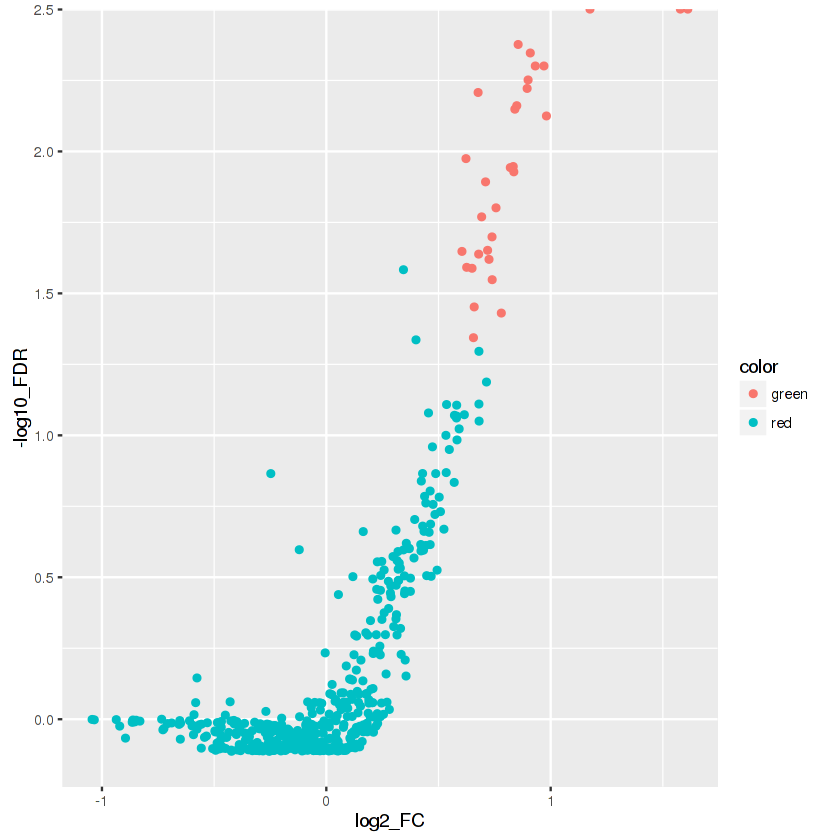

In [95]:
b_all <- topGene(RP.out, cutoff = 2, logged = TRUE, method="pfp",
               gene.names=row.names(toRP), logbase = 2)$Table2 %>% as.data.frame %>% rownames_to_column(var = 'micro')
all_rankprod = b_all %>% mutate(
    FC = ifelse(`FC:(class1/class2)` < 1, -1/`FC:(class1/class2)`, `FC:(class1/class2)`),
    log2_FC = ifelse(`FC:(class1/class2)` < 1, -log2(-FC), log2(FC)),
    log10_FDR = log10(pfp), 
    color = ifelse(pfp < 0.05 & abs(FC)>1.5,'green','red'))
all_rankprod %>% dim
ggplot(all_rankprod, aes(x=log2_FC, y = -log10_FDR, color=color)) + geom_point()

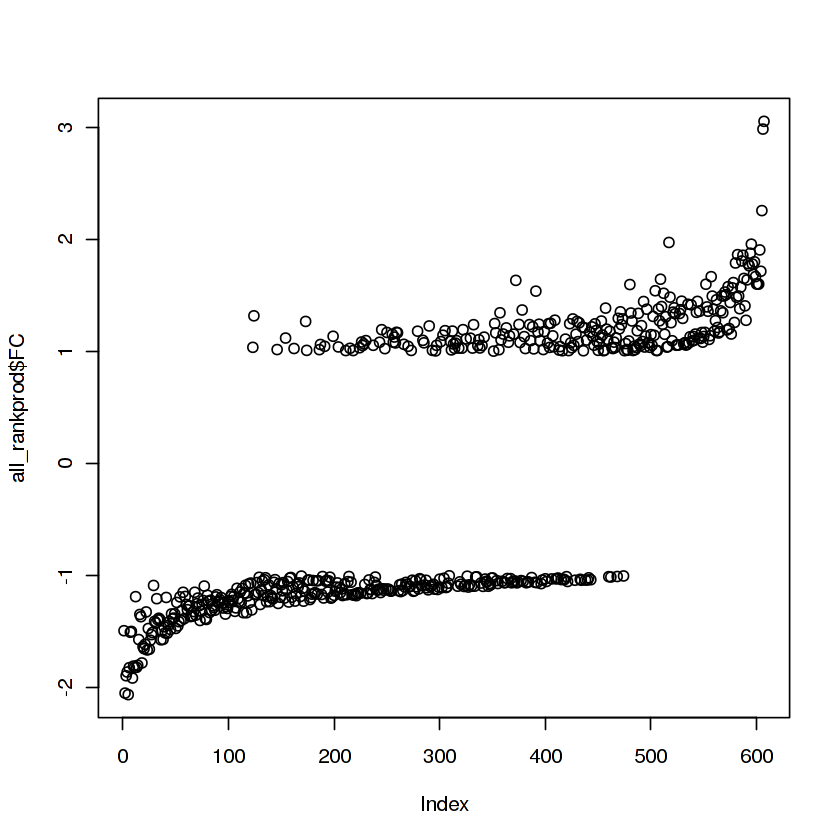

In [77]:
plot(all_rankprod$FC)

In [23]:
  b <- topGene(RP.out, cutoff = 0.05, logged = TRUE, method="pfp",
               gene.names=row.names(toRP), logbase = 2)$Table1 %>% as.data.frame %>% rownames_to_column(var = 'micro')
  a <- topGene(RP.out, cutoff = 0.05, logged = TRUE, method="pfp",
               gene.names=row.names(toRP), logbase = 2)$Table2 %>% as.data.frame %>% rownames_to_column(var = 'micro')
b %>% dim
a %>% dim
top_rankprod = b %>% bind_rows(a) %>% mutate(FC = ifelse(`FC:(class1/class2)` < 1, 1/`FC:(class1/class2)`, `FC:(class1/class2)`)) %>%
filter(FC > 1.5) %>% arrange(desc(FC))

write_csv(top_rankprod,'~/Downloads/tmp/top_rankprod_full.csv')


# list of top microRNAs for enrichment with mirpath: http://snf-515788.vm.okeanos.grnet.gr/index.php?r=mirpath/index
write_csv(top_rankprod %>% dplyr::select(micro),'~/Downloads/tmp/top_rankprod.csv', col_names = F)

top_rankprod %>% mutate(nn = nrow(.)) %>% head

Table1: Genes called significant under class1 < class2 

Table2: Genes called significant under class1 > class2 

Table1: Genes called significant under class1 < class2 

Table2: Genes called significant under class1 > class2 



[1] 30  6

[1] 33  6

,micro,gene.index,RP/Rsum,FC:(class1/class2),pfp,P.value,FC,nn
1,hsa-miR-3182,274,25.1377,3.0550,0.0000,0,3.055000,52
2,hsa-miR-889-3p,588,27.4540,2.9858,0.0000,0,2.985800,52
3,hsa-miR-127-5p,57,49.8041,2.2582,0.0000,0,2.258200,52
4,hsa-miR-4750-5p,429,60.2936,0.4850,0.0000,0,2.061856,52
5,hsa-miR-483-3p,435,56.7032,0.4883,0.0000,0,2.047921,52
6,hsa-miR-509-3-5p,463,61.1316,1.9740,0.0075,0,1.974000,52


## pca

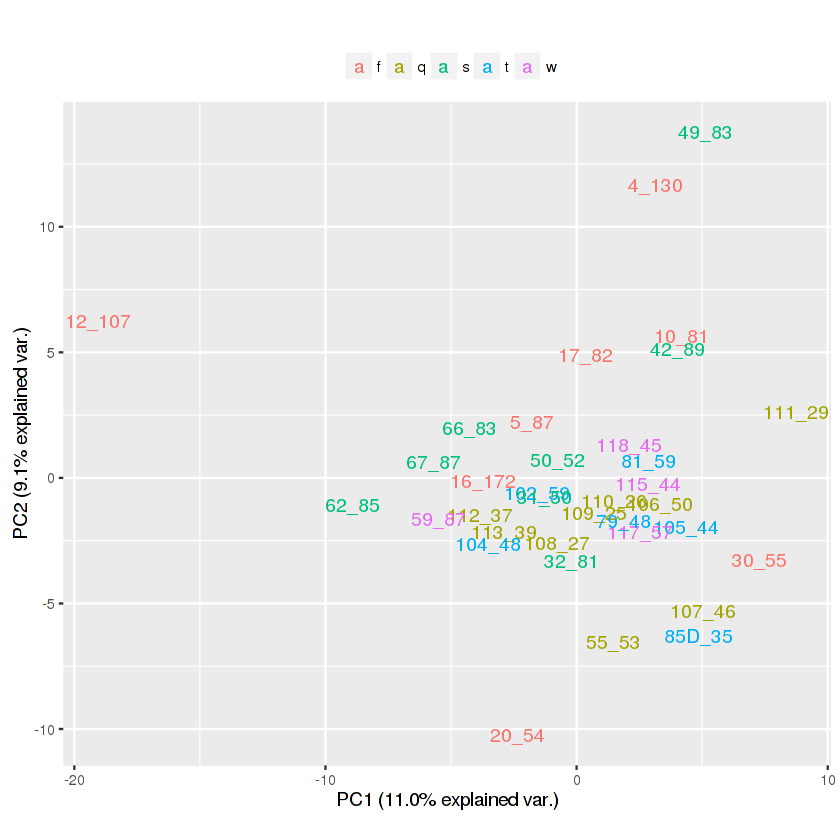

In [24]:
ir.pca <- prcomp(log.nc.filt %>% t)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 1:2, labels.size = 4,
              ellipse = F, circle = F, groups = pheno$batch,
              var.axes = F, labels = paste(pheno$pat %>% as.character, round(pheno$DLCO),sep='_'))
g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

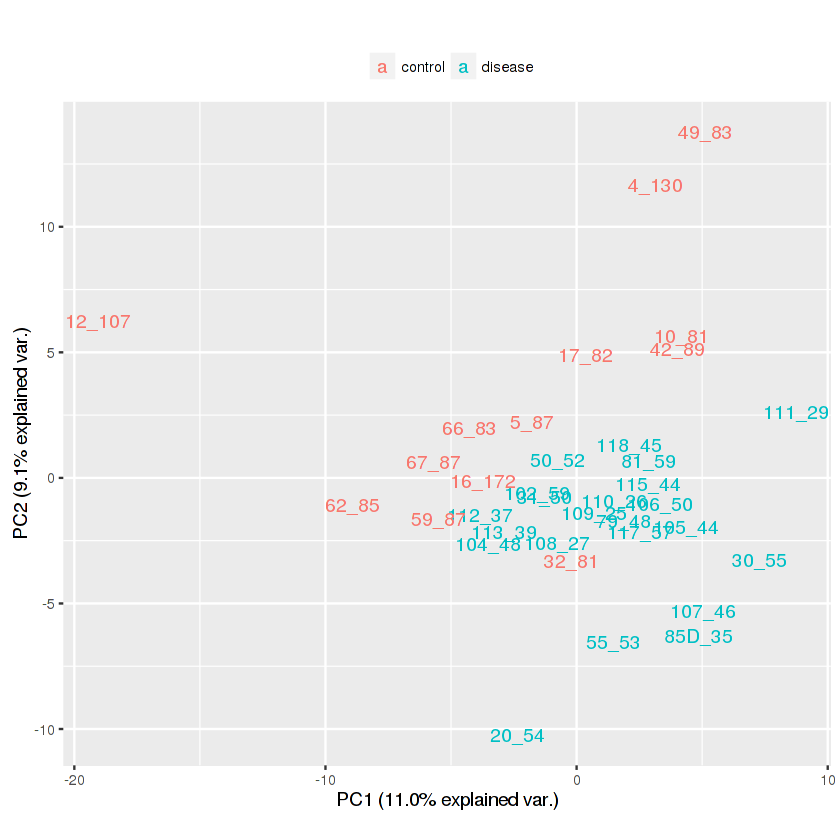

In [25]:
ir.pca <- prcomp(log.nc.filt %>% t)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 1:2, labels.size = 4,
              ellipse = F, circle = F, groups = pheno$dlco_group,
              var.axes = F, labels = paste(pheno$pat %>% as.character, round(pheno$DLCO),sep='_'))
g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

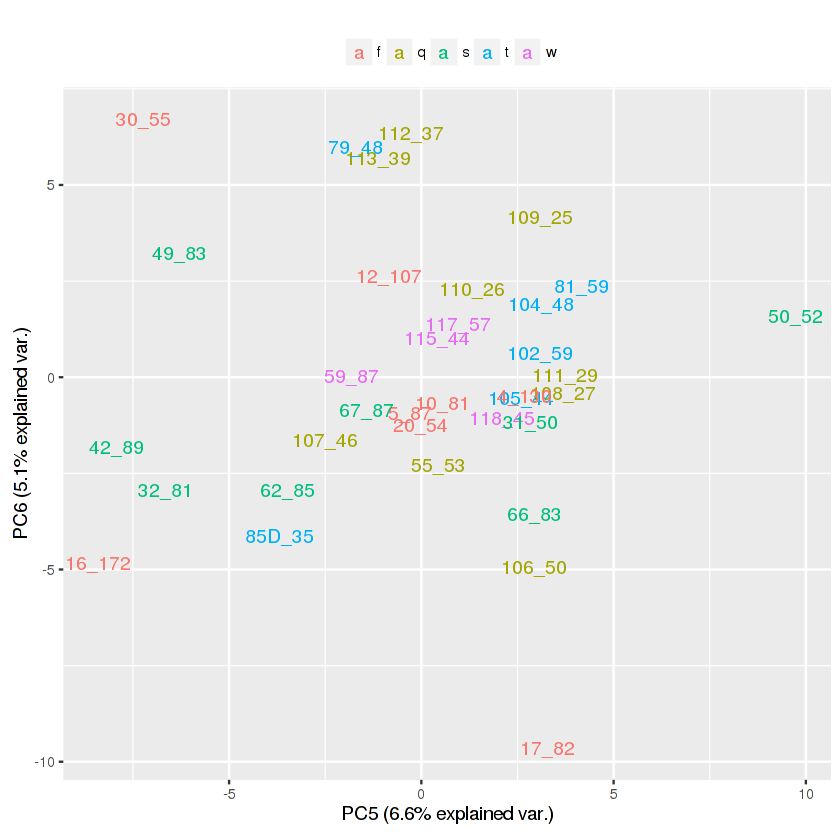

In [26]:
ir.pca <- prcomp(log.nc.filt %>% t)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 5:6, labels.size = 4,
              ellipse = F, circle = F, groups = pheno$batch,
              var.axes = F, labels = paste(pheno$pat %>% as.character, round(pheno$DLCO),sep='_'))
g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

## tops: dlco vs log value

In [27]:
log.melt = 
  #log.nc.filt[row.names(log.nc.filt) %in% row.names(pvals[1:limma_fdr_batchage05,]),] %>% 
  #log.nc.filt[row.names(log.nc.filt) %in% row.names(pvals[1:10,]),] %>% 
  log.nc.filt[row.names(log.nc.filt) %in% mirs$genes,] %>% 
  data.frame %>% mutate(mir = row.names(.)) %>% melt(id.vars = 'mir') %>%
  mutate(file = variable)
log.melt$file = as.character(log.melt$file) %>% gsub('X1','1',.)
log.melt %<>% rowwise %>% mutate(
  micro = mir, #strsplit(mir,split='\\|')[[1]][4],
  patient = strsplit(file,split='_')[[1]][1],      
  pat = gsub('RF\\.','',patient),
  pat = gsub('RF','',pat),
  pat = gsub('\\.1','',pat),
  pat = gsub('\\.2','',pat),
  pat = gsub('\\.3','',pat)) %>% ungroup %>% 
  left_join(groups[,c('pat','batch','Edad','DLCO')])

Joining, by = "pat"


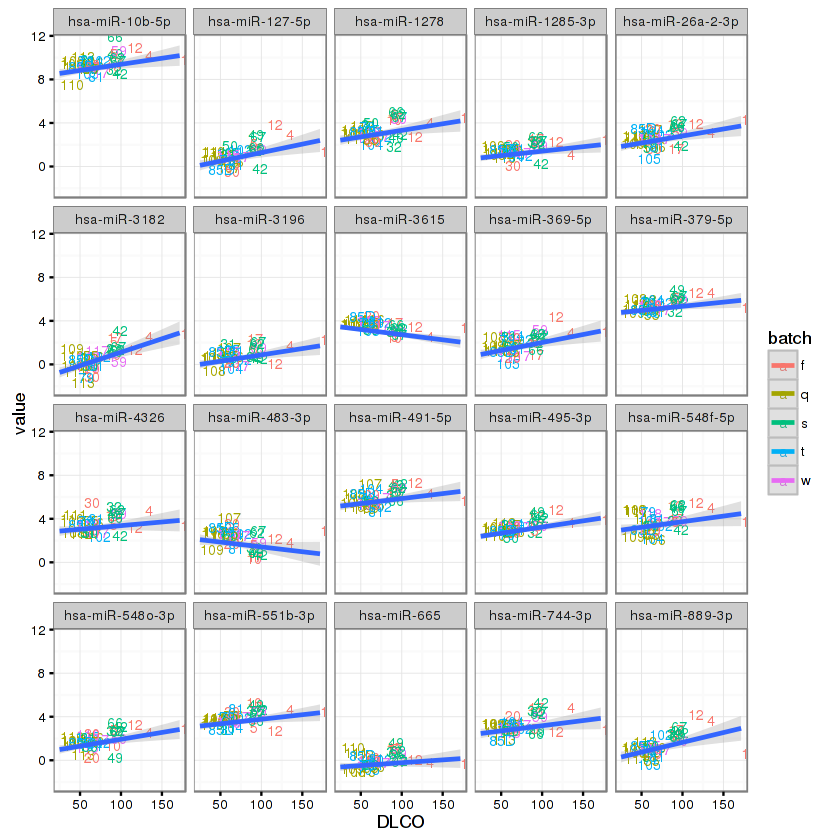

In [28]:
ggplot(log.melt, aes(x = DLCO, y = value, color = batch)) +
  geom_text(aes(label=as.character(pat)),hjust=0, vjust=0, size = 3) +
  #  geom_point(size = 5) + 
  geom_smooth(aes(x = DLCO, y = value, color = batch, group = micro), method=lm, alpha = 0.3) +
  facet_wrap(~ micro) + theme_bw(10) 
top_mics = log.melt$micro %>% unique 

## tops: heatmap

In [29]:
log.melt = 
  #log.nc.filt[row.names(log.nc.filt) %in% row.names(pvals[1:limma_fdr_batchage05,]),] %>% 
  #log.nc.filt[row.names(log.nc.filt) %in% row.names(pvals[1:50,]),] %>% 
  #log.nc.filt[row.names(log.nc.filt) %in% mirs$genes,] %>% 
  log.nc.filt[row.names(log.nc.filt) %in% top_rankprod$micro,] %>% 
  data.frame %>% mutate(mir = row.names(.)) %>% melt(id.vars = 'mir') %>%
  mutate(file = variable)
log.melt$file = as.character(log.melt$file) %>% gsub('X1','1',.)
log.melt %<>% rowwise %>% mutate(
  micro = mir, #strsplit(mir,split='\\|')[[1]][4],
  patient = strsplit(file,split='_')[[1]][1],      
  pat = gsub('RF\\.','',patient),
  pat = gsub('RF','',pat),
  pat = gsub('\\.1','',pat),
  pat = gsub('\\.2','',pat),
  pat = gsub('\\.3','',pat)) %>% ungroup %>% 
  left_join(groups[,c('pat','batch','Edad','DLCO')])
log.melt %>% colnames
log.melt %>% class

Joining, by = "pat"


[1] "mir"      "variable" "value"    "file"     "micro"    "patient" 
 [7] "pat"      "batch"    "Edad"     "DLCO"

[1] "tbl_df"     "data.frame"

In [30]:
x = log.melt %>% dplyr::select(micro,pat,value)  %>% spread(.,micro,value)

In [31]:
row.names(x) = x$pat %>% as.character
##row.names(x)
cov = data_frame(pat = row.names(x)) %>% left_join(log.melt %>% dplyr::select(pat, DLCO) %>% distinct)
cov3 = data_frame(pat = row.names(x)) %>% left_join(pheno %>% distinct)
cov2 = data_frame(pat = row.names(x)) %>% left_join(log.melt %>% dplyr::select(pat, batch) %>% distinct)
row.names(x) = cov$DLCO
x %<>% select(-pat)
#x %>% head
#row.names(x)
#paste(pheno$patient,pheno$DLCO,pheno$dlco_group,var2,sep='_')
#colnames(x) %>% head
#cov3 %>% head

Joining, by = "pat"
Joining, by = "pat"
Joining, by = "pat"


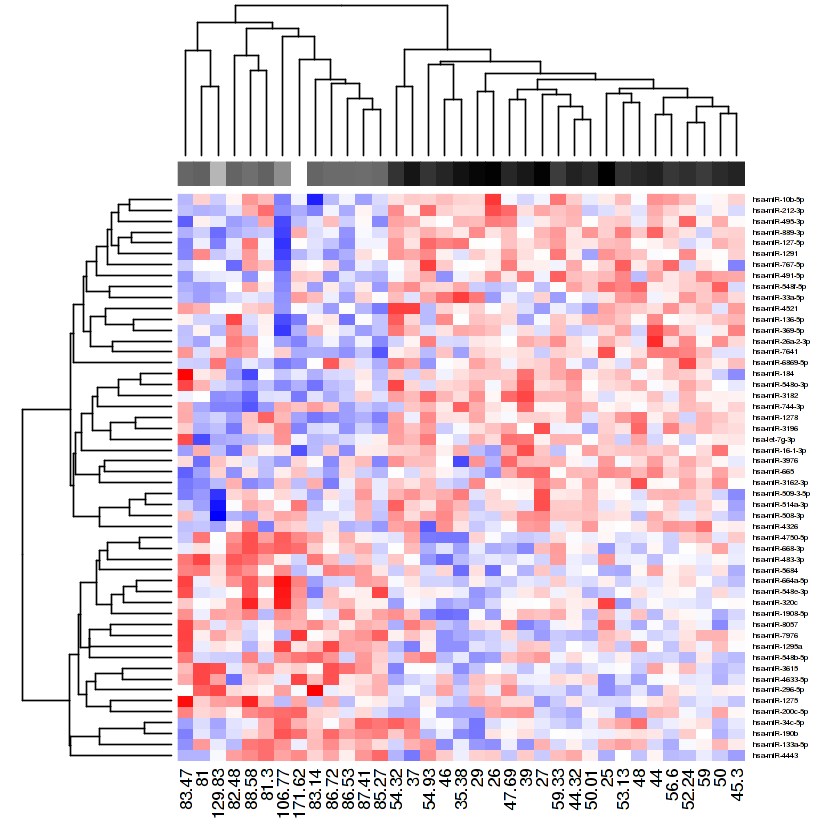

In [32]:
clust_methods = c("ward.D","ward.D2","single","complete","average","mcquitty","median","centroid")
dist.pear <- function(x) as.dist(1-cor(t(x)))
hclust.ave <- function(x) hclust(x, method=clust_methods[5])
hmcols<-colorRampPalette(c("red","white","blue"))(256)
hmcol<-brewer.pal(11,"RdBu")

var1 <- cov3$batch
var1 <- replace(var1, which(var1 == 'f'), "deepskyblue")
var1 <- replace(var1, which(var1 == 'q'), "magenta")
var1 <- replace(var1, which(var1 == 's'), "blue")
var1 <- replace(var1, which(var1 == 't'), "green")
var1 <- replace(var1, which(var1 == 'w'), "red")

var2 <- cov3$dlco_group
var2 <- replace(var2, which(var2 == 'disease'), "magenta")
var2 <- replace(var2, which(var2 == 'control'), "deepskyblue")
    
heatmap(x %>% as.matrix %>% t, 
        #ColSideColors= var2, 
        ColSideColors= color.scale(cov3$DLCO),
        col=hmcols, 
        distfun=dist.pear, hclustfun=hclust.ave,
        cexRow = 0.5,cexCol = 1.25)

In [33]:
row.names(pvals[1:65,])

[1] "hsa-miR-889-3p"    "hsa-miR-3615"      "hsa-miR-3196"     
 [4] "hsa-miR-379-5p"    "hsa-miR-491-5p"    "hsa-miR-1285-3p"  
 [7] "hsa-miR-495-3p"    "hsa-miR-1278"      "hsa-miR-744-3p"   
[10] "hsa-miR-548o-3p"   "hsa-miR-127-5p"    "hsa-miR-26a-2-3p" 
[13] "hsa-miR-4326"      "hsa-miR-548f-5p"   "hsa-miR-10b-5p"   
[16] "hsa-miR-551b-3p"   "hsa-miR-296-5p"    "hsa-miR-665"      
[19] "hsa-miR-369-5p"    "hsa-miR-483-3p"    "hsa-miR-3182"     
[22] "hsa-miR-5684"      "hsa-miR-7641"      "hsa-miR-4443"     
[25] "hsa-miR-494-3p"    "hsa-miR-212-3p"    "hsa-miR-4633-5p"  
[28] "hsa-miR-874-5p"    "hsa-miR-3074-3p"   "hsa-miR-125a-5p"  
[31] "hsa-miR-3120-5p"   "hsa-miR-664a-5p"   "hsa-miR-1295a"    
[34] "hsa-miR-375"       "hsa-miR-224-5p"    "hsa-miR-324-3p"   
[37] "hsa-miR-320c"      "hsa-miR-653-5p"    "hsa-miR-668-3p"   
[40] "hsa-miR-17-3p"     "hsa-miR-200c-3p"   "hsa-miR-423-3p"   
[43] "hsa-miR-499b-3p"   "hsa-miR-410-5p"    "hsa-miR-181b-5p"  
[46] "hsa-miR-539-3p"    "hsa-miR-99a-5p"    "hsa-miR-1247-3p"  
[49] "hsa-miR-3909"      "hsa-miR-29a-3p"    "hsa-miR-1291"     
[52] "hsa-miR-23b-5p"    "hsa-miR-8057"      "hsa-miR-27b-5p"   
[55] "hsa-miR-6869-5p"   "hsa-miR-152-3p"    "hsa-miR-204-5p"   
[58] "hsa-miR-134-5p"    "hsa-miR-452-5p"    "hsa-miR-4532"     
[61] "hsa-miR-152-5p"    "hsa-let-7g-3p"     "hsa-miR-338-5p"   
[64] "hsa-miR-7976"      "hsa-miR-125b-2-3p"

## heatmap raw counts

In [34]:
clust_methods = c("ward.D","ward.D2","single","complete","average","mcquitty","median","centroid")
dist.pear <- function(x) as.dist(1-cor(t(x)))
hclust.ave <- function(x) hclust(x, method=clust_methods[5])
hmcols<-colorRampPalette(c("red","white","blue"))(256)
hmcol<-brewer.pal(11,"RdBu")

var1 <- pheno$batch
var1 <- replace(var1, which(var1 == 'f'), "deepskyblue")
var1 <- replace(var1, which(var1 == 'q'), "magenta")
var1 <- replace(var1, which(var1 == 's'), "blue")
var1 <- replace(var1, which(var1 == 't'), "green")
var1 <- replace(var1, which(var1 == 'w'), "red")

var2 <- pheno$dlco_group
var2 <- replace(var2, which(var2 == 'disease'), "magenta")
var2 <- replace(var2, which(var2 == 'control'), "deepskyblue")
    
#heatmap(log.nc %>% as.matrix, 
 #       ColSideColors= var2, 
  #      #ColSideColors= color.scale(pheno$DLCO),
   #     col=hmcols, 
    #    distfun=dist.pear, hclustfun=hclust.ave,
     #   cexRow = 0.5,cexCol = 1.25)

# check micro lists

In [35]:
top_rankprod_df = data_frame(micro = str_replace(top_rankprod$micro,'hsa-','')) %>%
    mutate(micro = str_replace(micro,'-[35]p',''),
          micro = str_replace(micro,'-[123]$','')) %>% distinct(micro)
top_rankprod_df %>% dim

all_micros = data_frame(micro = str_replace(row.names(log.nc.filt),'hsa-','')) %>%
    mutate(micro = str_replace(micro,'-[35]p','')
           ,micro = str_replace(micro,'-[123]$','')
          ) %>% distinct(micro)
write_csv(all_micros,'~/Downloads/all_micros.csv')
all_micros %>% dim

# 2015 review: Non-coding RNAs in the pathogenesis of COPD
## figure 1: micro list:
review_2015_micros = data_frame(
    micro =c('miR-146a','let-7c','miR-135b','miR-15b','miR-144',
             'miR-452','miR-638','miR-218','miR-101','miR-199a',
            'miR-34b','miR-34c'), # 12 in total
    micro_order = c('down','down','up','up','up','down','up','down',
                   'up','down','down','down'))

## number of review_2015_micros found/not found in top rankprod list:
print("2015 review vs RankProd micros:")
top_rankprod_df %>% filter(micro %in% review_2015_micros$micro) %>% 
left_join(review_2015_micros,by='micro') %>% group_by(micro_order) %>% summarise(n(),
            micros = paste(micro[1:n()],collapse = ', '))

## number of review_2015_micros found/not found in micro matrix:
print("2015 review vs all micros:")
all_micros %>% filter(micro %in% review_2015_micros$micro) %>% 
left_join(review_2015_micros,by='micro') %>% group_by(micro_order) %>% summarise(n(),
               micros = paste(micro[1:n()],collapse = ', '))

## miR-96 
print('miR-96 vs RankProd:')
grepl('-96',top_rankprod$micro) %>% sum

## Downregulation of microRNA expression in the lungs of rats exposed to cigarette smoke
rats_micro = data_frame(
    micro =c("miR-10", "miR-26", "miR-30", "miR-34", "miR-99", 
             "miR-122", "miR-123", "miR-124", "miR-125", "miR-140", 
             "miR-145", "miR-146", "miR-191", "miR-192", "miR-219", 
             "miR-222", "miR-223", "miR-294"), # 12 in total
    micro_order = c( rep('down',17),'up'))

print('lungs of rats exposed to cigarette smoke vs Rankprod:')
top_rankprod_df %>% filter(micro %in% rats_micro$micro) %>% 
left_join(rats_micro,by='micro') %>% group_by(micro_order) %>% summarise(n(),
            micros = paste(micro[1:n()],collapse = ', '))

print('lungs of rats exposed to cigarette smoke vs all micros:')
all_micros %>% filter(micro %in% rats_micro$micro) %>% 
left_join(rats_micro,by='micro') %>% group_by(micro_order) %>% summarise(n(),
               micros = paste(micro[1:n()],collapse = ', '))

[1] 52  1

[1] 448   1

[1] "2015 review vs RankProd micros:"


,micro_order,n(),micros
1,down,1,miR-34c


[1] "2015 review vs all micros:"


,micro_order,n(),micros
1,down,7,"let-7c, miR-146a, miR-199a, miR-218, miR-34b, miR-34c, miR-452"
2,up,4,"miR-101, miR-135b, miR-144, miR-15b"


[1] "miR-96 vs RankProd:"


[1] 0

[1] "lungs of rats exposed to cigarette smoke vs Rankprod:"


,micro_order,n(),micros


[1] "lungs of rats exposed to cigarette smoke vs all micros:"


,micro_order,n(),micros
1,down,6,"miR-140, miR-145, miR-191, miR-192, miR-222, miR-223"


In [36]:
rep('15',15)

[1] "15" "15" "15" "15" "15" "15" "15" "15" "15" "15" "15" "15" "15" "15" "15"

## miRNAs target prediction